In [8]:
import pandas as pd
import matplotlib
import numpy as np 
from os.path import join as os_join
from textwrap import wrap
import itertools
import json
import os
import glob
from typing import List, Tuple, Dict


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = "serif"

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=2)

from tqdm.notebook import tqdm as tqdm
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import sys
sys.path.insert(0, "/home/xingzguo/git_project/DynMixer/src")
sys.path.insert(0, "/home/xingzguo/git_project/DynMixer/src/DynGL")
sys.path.insert(0, "/home/xingzguo/git_project/DynMixer/src/DynGLReaders")

from Mixer.PPRGNN_utils import (
    ModelPerfResult,
    ModelTrainTimeResult,
    SnapshotTrainEvalRecord,
)

from DynGL.DynPageRank.DynPPRAlgos import PPVResult

local_res_path = '/home/xingzguo/git_project/DynMixer/cache'
colors_palette = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)
#'tab:blue', 'tab:orange', 'tab:green', 
# 'tab:red', 'tab:purple', 'tab:brown', 
#  tab:pink', 'tab:gray', 'tab:olive', 
# 'tab:cyan', 



# Visualize experiment results for node classification

In [9]:
def get_df_res(local_res_path, exp_name, clf_alpha):
    local_exp_res_path = os_join(local_res_path, exp_name, 'df-exp-result*.pkl' )
    res_files = glob.glob(local_exp_res_path)
    df_list:List[pd.DataFrame] = []
    for i, file_path in enumerate(res_files):
        #print(i,file_path)
        df_list.append(pd.read_pickle(file_path))
    df_all_exp_res = pd.concat(df_list, ignore_index = True)
    # for example, only show alpha=0.15
    df_all_exp_res =df_all_exp_res[df_all_exp_res['alpha'] == clf_alpha]
    # df_all_exp_res =df_all_exp_res[df_all_exp_res['ppr_algo'] == 'power_iteration']
    print('total after alpha filtering:', df_all_exp_res.shape[0])
    return df_all_exp_res


def get_perf_metric_all_epochs(perf_report_all_epochs:List[ModelPerfResult]):
    num_epochs = len(perf_report_all_epochs)
    return_list:List[Dict] = []
    for epoch_id in range(num_epochs):
        _dict = get_subset_perf_metric(perf_report_all_epochs[epoch_id])
        return_list.append(_dict)
    return return_list

def get_subset_perf_metric(perf_report:ModelPerfResult):
    """
        2. get snapshot-level stats (train/dev), for one snapshot:
        *  loss per epoch: List[float] 
        *  auc per epoch: List[float]
        *  Macro-F1 per epoch: List[float]
        *  WAvg-F1 per epoch: List[float]
        *  Avg-Acc per epoch: List[float]
    """
    loss = perf_report.loss
    acu = perf_report.roc_auc
    clf_report = perf_report.clf_report
    # print(clf_report)
    #NOTE: we can add more infor here
    _dict = {
            'loss':loss,
            'acu':acu,
            'macro_precision': clf_report['macro avg']['precision'],
            'macro_recall': clf_report['macro avg']['recall'],
            'macro_f1': clf_report['macro avg']['f1-score'],
            'support': clf_report['macro avg']['support'],
            'accuracy': clf_report['accuracy'],
            # 'micro_f1': clf_report['micro avg']['f1-score'],

        }
    return _dict

def get_subset_time_metric(time_result:ModelTrainTimeResult):
    return  {
        'graph_update_time': time_result.graph_update_time,
        'ppr_update_time': time_result.ppr_update_time,
        'model_prepare_input_train': time_result.model_prepare_input_train,
        'model_prepare_input_dev':time_result.model_prepare_input_dev,
        'model_forback_mean': np.mean(time_result.model_forback_per_epoch),
        'model_forback_std': np.std(time_result.model_forback_per_epoch),
    }

def get_train_dev_stats(df_all_exp_res:pd.DataFrame, exp_idx:int):
    """ re-org cached results into performance/time of all snapshots 
    for table and plot.
    
    """
    snapshot_res_list:List[SnapshotTrainEvalRecord] = df_all_exp_res.iloc[exp_idx]['snapshot_results']
    num_snapshots = len(snapshot_res_list)
    
    train_stats_all_snapshots: List[Dict] = []
    dev_stats_all_snapshots: List[Dict] = []
    test_stats_all_snapshots: List[Dict] = []
    timing_stats_all_snapshots: List[Dict] = []
    ppv_stats_all_snapshots: List[Dict] = []
    
    for snapshot_id in range(num_snapshots):
        snapshot_res = snapshot_res_list[snapshot_id]
        assert snapshot_res.snapshot_id == snapshot_id, 'snapshot id does not match'
        
        # retreive all epoch performance
        perf_report_train_all_epochs = snapshot_res.perf_report_train_per_epoch
        perf_report_dev_all_epochs = snapshot_res.perf_report_dev_per_epoch
        
        
        if 'graph_ppv_dict' in snapshot_res.__dict__.keys():
            ppv_stats = snapshot_res.graph_ppv_dict
        else:
            ppv_stats = {}
        
        # get ppv stats for all snapshots
        ppv_stats_all_snapshots.append(ppv_stats)
        
        # get train/dev stats for all epochs in this snapshot.
        train_stats_epochs = get_perf_metric_all_epochs(perf_report_train_all_epochs)
        train_stats_epoch_last = train_stats_epochs[-1]
        dev_stats_epochs = get_perf_metric_all_epochs(perf_report_dev_all_epochs)
        dev_stats_epoch_last = dev_stats_epochs[-1]
        # NOTE:use last epoch to represent this snapshot
        train_stats_all_snapshots.append(train_stats_epoch_last)
        dev_stats_all_snapshots.append(dev_stats_epoch_last)
        
        # retreive test performance
        perf_report_test = snapshot_res.perf_report_test
        test_stats = get_subset_perf_metric(perf_report_test)
        test_stats_all_snapshots.append(test_stats)
        
        # retreive data/ppr/nn time metric
        train_time_result = snapshot_res.train_time_result
        timing_stats = get_subset_time_metric(train_time_result)
        timing_stats_all_snapshots.append(timing_stats)
        
    return (
            train_stats_all_snapshots, 
            dev_stats_all_snapshots, 
            test_stats_all_snapshots,
            timing_stats_all_snapshots,
            ppv_stats_all_snapshots,
            )


def give_plot_kwargs(df_all_exp_res:pd.DataFrame, exp_idx:int):
    """ set color/shape for plotting
    unify plot marker shape/color/linestyle
    
    """

    style_columns = ['aggregate_type', 'ppr_algo','mixrank_mode','polyrank_mode']
    df_style_val = df_all_exp_res.iloc[exp_idx][style_columns]
    
    aggregate_type = df_style_val['aggregate_type']
    ppr_algo = df_style_val['ppr_algo']
    mixrank_mode = df_style_val['mixrank_mode']
    polyrank_mode = df_style_val['polyrank_mode']

    # ppr-algo
    line_color_dict = {
        'ista': colors_palette['tab:blue'], 
        'power_iteration':colors_palette['tab:red'],
        'forward_push':colors_palette['tab:pink'],
    }
    

    # agg method
    marker_dict = {
        'ppe': '1',
        'goppe': 'o',
        'mlp': '>',
        'gaussian': 's',
        'pprgo': '<',
        'mixrank':'*',
        'polyrank': 'x',
    }

    
    # mixrank/polyrank variants
    markerface_color_dict = {
        #random_sample high_ppr low_ppr high_low_ppr all
        'all': colors_palette['tab:blue'], 
        'linear':colors_palette['tab:orange'],
        'softmax':colors_palette['tab:green'],
        'poly':colors_palette['tab:red'],
        'high_low_ppr': colors_palette['tab:purple'],
        'high_ppr':colors_palette['tab:brown'],
        'low_ppr':colors_palette['tab:pink'],
        'random_sample': colors_palette['tab:gray'],
    }
    
    # emphsize baseline pprog/mlp
    linewidth = 0.3
    alpha=0.6
    
    line_color = line_color_dict[ppr_algo]
    markerfacecolor = line_color
    marker_shape = marker_dict[aggregate_type]
    
    # if aggregate_type in ('mlp', 'gaussian'):
    #     label = f"{aggregate_type}"
    # elif aggregate_type in ('mixrank'):
    #     label = f"{aggregate_type}-{mixrank_mode}"
    #     markerfacecolor = markerface_color_dict[mixrank_mode]
    # elif aggregate_type in ('polyrank'):
    #     label = f"{aggregate_type}-{polyrank_mode}"
    #     markerfacecolor = markerface_color_dict[polyrank_mode]
    # elif aggregate_type in ('pprgo'):
    #     label = f"{aggregate_type}-{ppr_algo}"
    #     # linewidth = 1.0
    #     # alpha = 0.9
    # else:
    #     label = f"{aggregate_type}-{ppr_algo}"
    
    aggregate_type_map = {
        'mlp':'MLP',
        'gaussian':'Random',
        'goppe':'GoPPE',
        'ppe':'DynPPE',
        'mixrank':'InsGNN',
        'pprgo': 'PPRGo',
    }
    
    if aggregate_type in aggregate_type_map.keys():
        label = aggregate_type_map[aggregate_type] 
    else:
        label = aggregate_type
    # print(aggregate_type, line_color, markerfacecolor)

    return {
        'color' : line_color,
        'marker' : marker_shape,
        'markerfacecolor': markerfacecolor,
        'markeredgecolor': markerfacecolor,
        'linestyle' : '-',
        'linewidth' : linewidth,
        'markersize' : 5,
        'label':label,
        'alpha': alpha,
    }

def get_exp_plot_data(df_all_exp_res):
    num_all_exp = df_all_exp_res.shape[0]
    result_summary_dict = {}
    for exp_config_idx in range(num_all_exp):
        (
        train_stats_all_snapshots, 
        dev_stats_all_snapshots, 
        test_stats_all_snapshots,
        timing_stats_all_snapshots,
        ppv_stats_all_snapshots,
    ) = get_train_dev_stats(df_all_exp_res, exp_idx = exp_config_idx)

    # convert data for plotting easily
        plot_d_test_acc = []
        plot_d_test_mac_f1 = []
        num_snapshots = len(train_stats_all_snapshots)
        for snapshot_id in range(num_snapshots):
            train_perf_stats = train_stats_all_snapshots[snapshot_id]
            dev_perf_stats = dev_stats_all_snapshots[snapshot_id]
            test_perf_stats = test_stats_all_snapshots[snapshot_id]
            time_stats = timing_stats_all_snapshots[snapshot_id]
            plot_d_test_acc.append(test_perf_stats['accuracy'])
            plot_d_test_mac_f1.append(test_perf_stats['macro_f1'])

    # get plot settings: color/shape/size
        plt_plot_kwargs = give_plot_kwargs(
        df_all_exp_res,
        exp_idx = exp_config_idx,
        )
    
        dataset_name = df_all_exp_res['graph_dataset_name'].unique()[0]

        if 'accuracy' not in result_summary_dict:
            result_summary_dict['accuracy'] = []
        result_summary_dict['accuracy'].append(
        {
            'model': plt_plot_kwargs['label'],
            'data': plot_d_test_acc,
            'plt_plot_kwargs':plt_plot_kwargs,
        }
    )
        if 'macro-f1' not in result_summary_dict:
            result_summary_dict['macro-f1'] = []
        result_summary_dict['macro-f1'].append(
        {
            'model': plt_plot_kwargs['label'],
            'data': plot_d_test_mac_f1,
            'plt_plot_kwargs':plt_plot_kwargs
        }
    )
        
    return result_summary_dict


#### 3.1  plot performance metric for all snapshots

total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
save to  /home/xingzguo/git_project/DynMixer/results/exp-1-v201/fig-clf-exp-1-all-acc.pdf
total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
total after alpha filtering: 21
save to  /home/xingzguo/git_project/DynMixer/results/exp-1-v201/fig-clf-exp-1-all-macro-f1.pdf


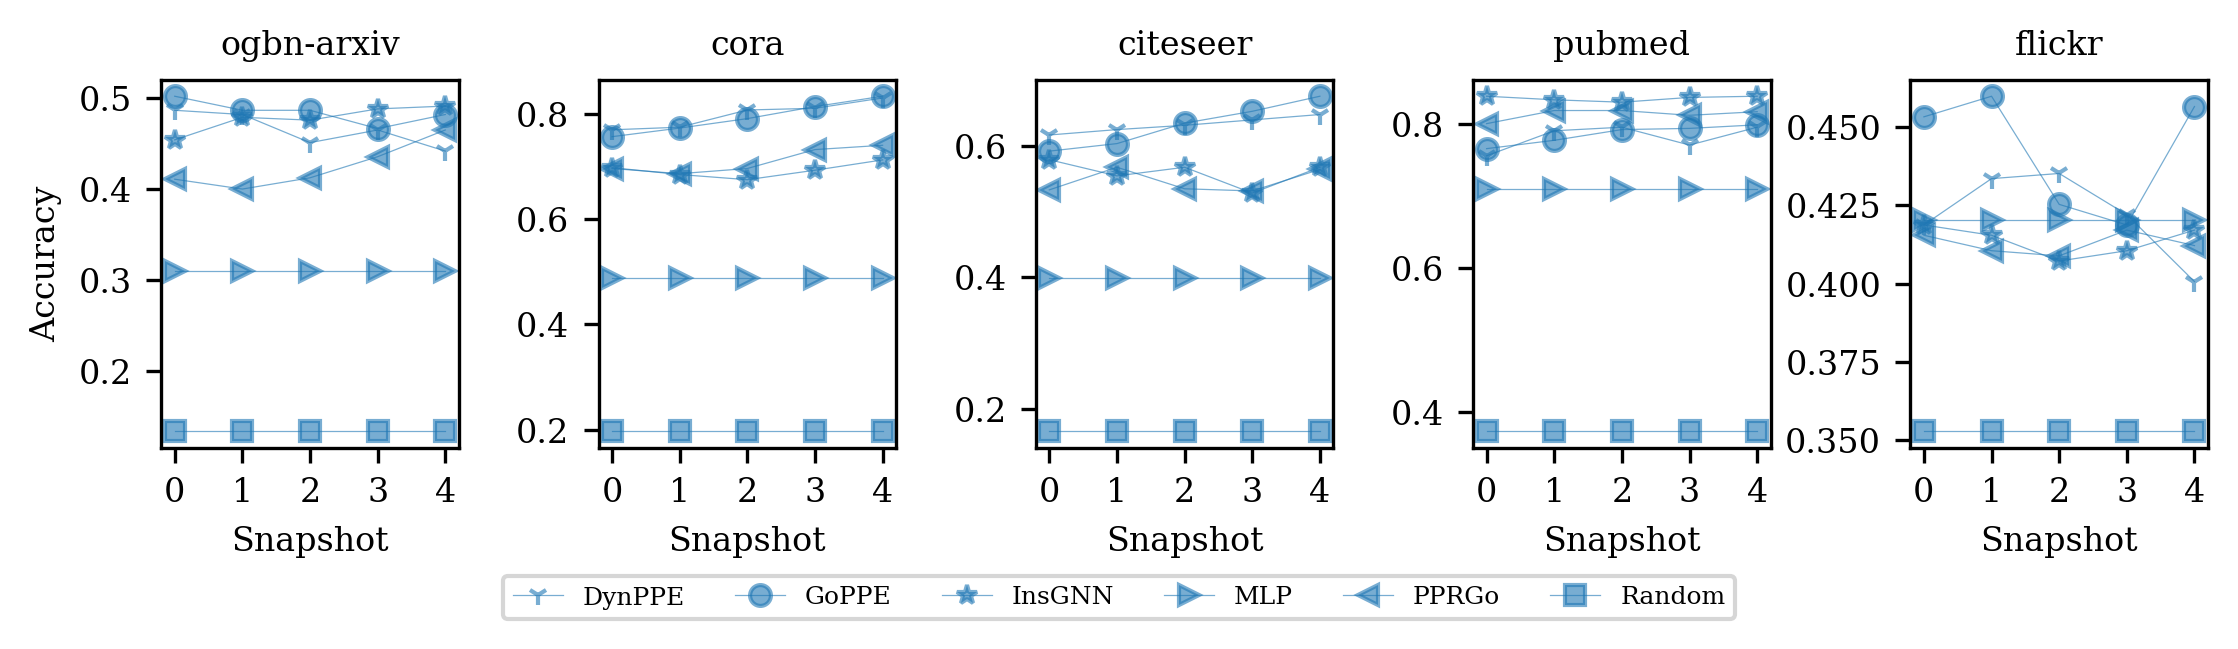

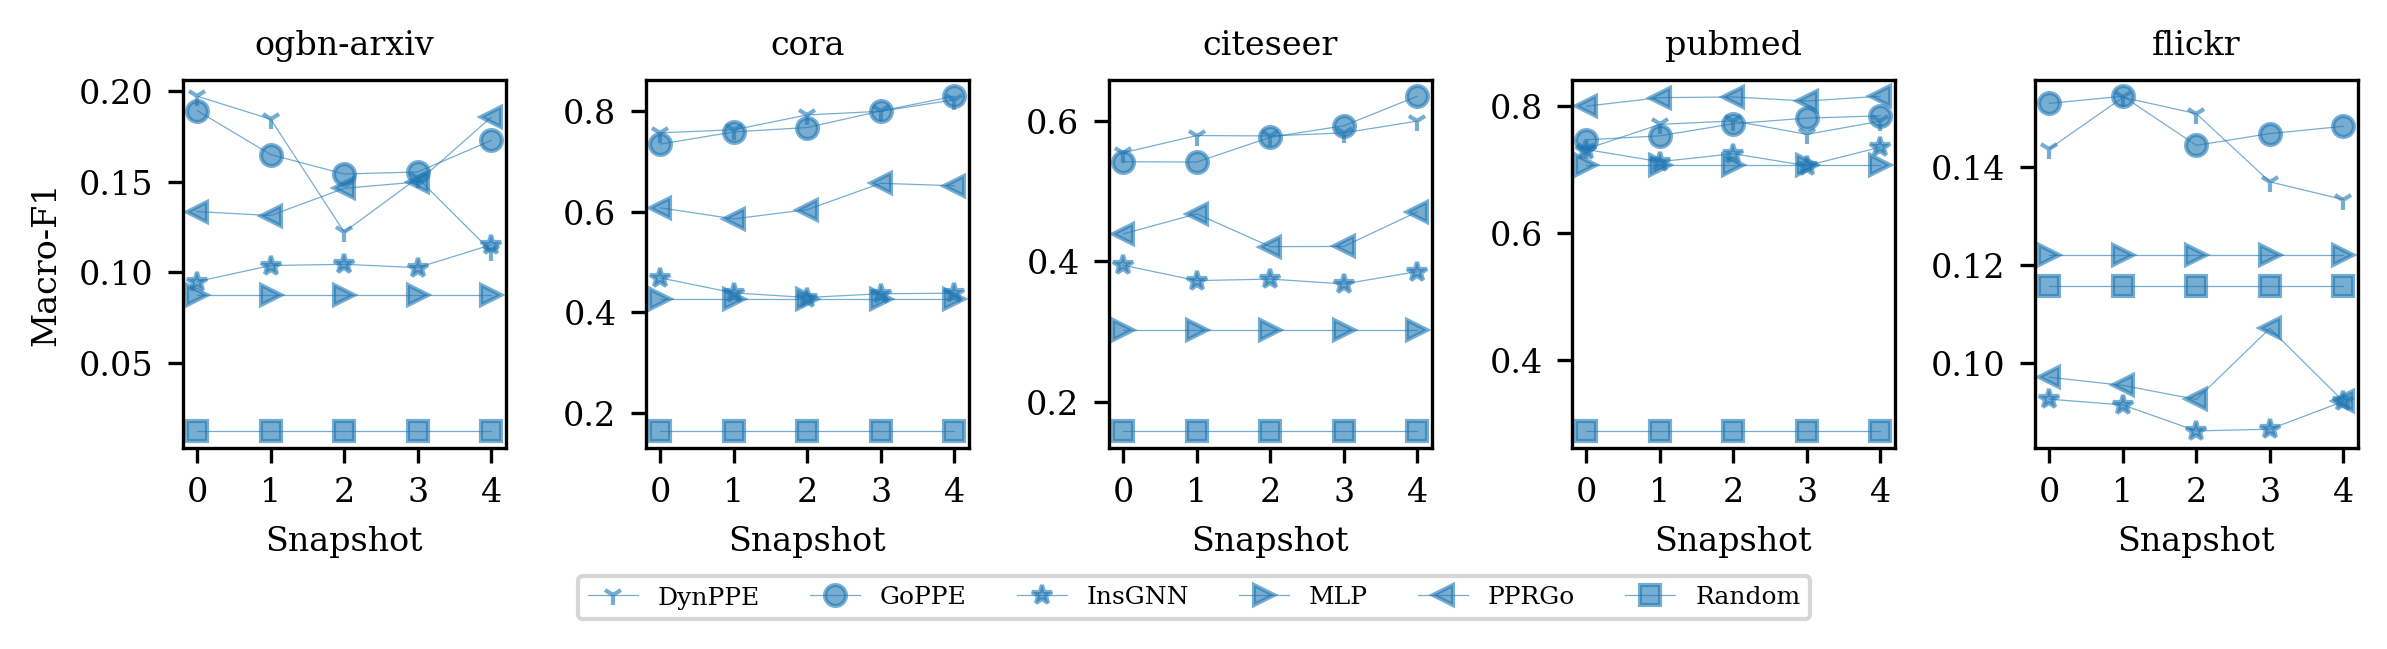

In [3]:

version = 201
# 201 is the latest verion 
# 202 is runnong on pascal for arxiv graph with 50 epochs ---not work
# 203/4 is runnong on pangu for pubmed 50/100 epochs---not work
# 205 is for pubed with 100 eppoch with double mlps for fusion

plot_exp_list = [
    {
        "exp_name": f'exp-1-ogbn-arxiv-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'ogbn-arxiv'
        },    
    {
        "exp_name": f'exp-1-cora-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'cora'
        },
    {
        "exp_name": f'exp-1-citeseer-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'citeseer'
        },
    {
        "exp_name": f'exp-1-pubmed-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'pubmed'
        },
    {
        "exp_name": f'exp-1-flickr-debug-{version}', 
        "clf_alpha": 0.30, 
        "graph": 'flickr'
        },
]
res_dir = f'/home/xingzguo/git_project/DynMixer/results/exp-1-v{version}/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

table_ppr_avg_record = []

fig, axes = plt.subplots(1,5, figsize = (7.5, 2.0), dpi=300)
axes = np.array([axes])
axes = axes.flatten()
for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    _df_all_exp_res = get_df_res(local_res_path, exp_name, clf_alpha)
    _df_all_exp_res= _df_all_exp_res[_df_all_exp_res['mixrank_mode']!='random_sample']
    # print('df_all_exp_res.shape', df_all_exp_res.shape)
    result_summary_dict = get_exp_plot_data(_df_all_exp_res)

    plot_kwargs_dict = {}
    agg_res = {}
    for _record in result_summary_dict['accuracy']:
        plot_kwargs_dict[_record['model']] = _record['plt_plot_kwargs']
        if _record['model'] not in agg_res:
            agg_res[_record['model']] = []
        agg_res[_record['model']].append(_record['data'])
        

        
    for model, acc in agg_res.items():
        # plot acc
        ax = axes[ax_i]
        if ax_i == 0:
            ax.set_ylabel('Accuracy')
        ax.set_xlabel('Snapshot')
        # ax.set_title(f'Accuracy (dataset:{dataset_name})')
        # ax.set_title(f'Accuracy')
        ax.set_title(graph_name)
        ax.plot(np.mean(acc, axis = 0), **plot_kwargs_dict[model])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        table_ppr_avg_record.append(
            {
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":model,
                "accuracy-mean": np.mean(acc),
                "accuracy-std": np.std(acc),
            }
        )
        
        # if model == 'InsGNN':
        #     print(acc)


handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=6, loc='upper center', bbox_to_anchor=(0.5, 0.05), prop={'size': 6})
fig.tight_layout()
fig_path = os_join(res_dir, f'fig-clf-exp-1-all-acc.pdf')
print('save to ', fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')


fig, axes = plt.subplots(1,5, figsize = (8, 2.0), dpi=300)
axes = np.array([axes])
axes = axes.flatten()
for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    _df_all_exp_res = get_df_res(local_res_path, exp_name, clf_alpha)
    # print('df_all_exp_res.shape', df_all_exp_res.shape)
    result_summary_dict = get_exp_plot_data(_df_all_exp_res)

    plot_kwargs_dict = {}
    agg_res = {}
    for _record in result_summary_dict['macro-f1']:
        plot_kwargs_dict[_record['model']] = _record['plt_plot_kwargs']
        if _record['model'] not in agg_res:
            agg_res[_record['model']] = []
        agg_res[_record['model']].append(_record['data'])
    for model, acc in agg_res.items():
        # plot acc
        ax = axes[ax_i]
        if ax_i == 0:
            ax.set_ylabel('Macro-F1')

        ax.set_xlabel('Snapshot')
        # ax.set_title(f'Accuracy (dataset:{dataset_name})')
        # ax.set_title(f'Accuracy')
        ax.set_title(graph_name)
        ax.plot(np.mean(acc, axis = 0), **plot_kwargs_dict[model])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))


handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=6, loc='upper center', bbox_to_anchor=(0.5, 0.05), prop={'size': 6})
fig.tight_layout()
fig_path = os_join(res_dir, f'fig-clf-exp-1-all-macro-f1.pdf')
print('save to ', fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')



### plot tables exp1

In [4]:
df_all_ppr_res = pd.DataFrame.from_records(table_ppr_avg_record)
# print(df_all_ppr_res)
select_cols = ['dataset', 'ppr-algo', 'accuracy-mean', 'accuracy-std'] #'l1-err-mean',
df_select_ppr_res = df_all_ppr_res[df_all_ppr_res["ppr-algo"]!= "mixrank-random_sample"][select_cols]

# df_ppr_time = df_select_ppr_res.set_index(['increment', 'ppr-algo'])
df_acc_mean = pd.pivot_table(df_select_ppr_res, index = ['ppr-algo'], columns=['dataset'], values= "accuracy-mean").reset_index()
df_acc_std = pd.pivot_table(df_select_ppr_res, index = ['ppr-algo'], columns=['dataset'], values= "accuracy-std").reset_index()

col_reorder = ["ppr-algo", "cora", "citeseer", "pubmed", "ogbn-arxiv", "flickr"]
# col_reorder = ["ppr-algo", "cora", "citeseer", "pubmed",]
df_acc_mean = df_acc_mean[col_reorder].sort_values(['ppr-algo', ], ascending = [True]).set_index("ppr-algo", drop=True)
# row_reorder = ["gaussian", "mlp", "pprgo-ista","mixrank-all","ppe-ista", "goppe-ista" ]
row_reorder = ["Random", "MLP", "PPRGo","InsGNN","DynPPE", "GoPPE" ]

df_acc_mean = df_acc_mean.reindex(row_reorder)
print(df_acc_mean.to_latex(float_format="%.4f"))

# df_acc_std

\begin{tabular}{lrrrrr}
\toprule
dataset &   cora &  citeseer &  pubmed &  ogbn-arxiv &  flickr \\
ppr-algo &        &           &         &             &         \\
\midrule
Random   & 0.1977 &    0.1667 &  0.3731 &      0.1343 &  0.3530 \\
MLP      & 0.4886 &    0.3987 &  0.7098 &      0.3102 &  0.4204 \\
PPRGo    & 0.7101 &    0.5458 &  0.8139 &      0.4244 &  0.4128 \\
InsGNN   & 0.6925 &    0.5588 &  0.8362 &      0.4772 &  0.4138 \\
DynPPE   & 0.7984 &    0.6314 &  0.7821 &      0.4648 &  0.4220 \\
GoPPE    & 0.7935 &    0.6310 &  0.7861 &      0.4843 &  0.4427 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8179/1634873913.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_acc_mean.to_latex(float_format="%.4f"))


#### for exp2


total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
save to  /home/xingzguo/git_project/DynMixer/results/exp-2-v201/fig-clf-exp-1-all-acc.pdf
total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
total after alpha filtering: 15
save to  /home/xingzguo/git_project/DynMixer/results/exp-2-v201/fig-clf-exp-1-all-macro-f1.pdf


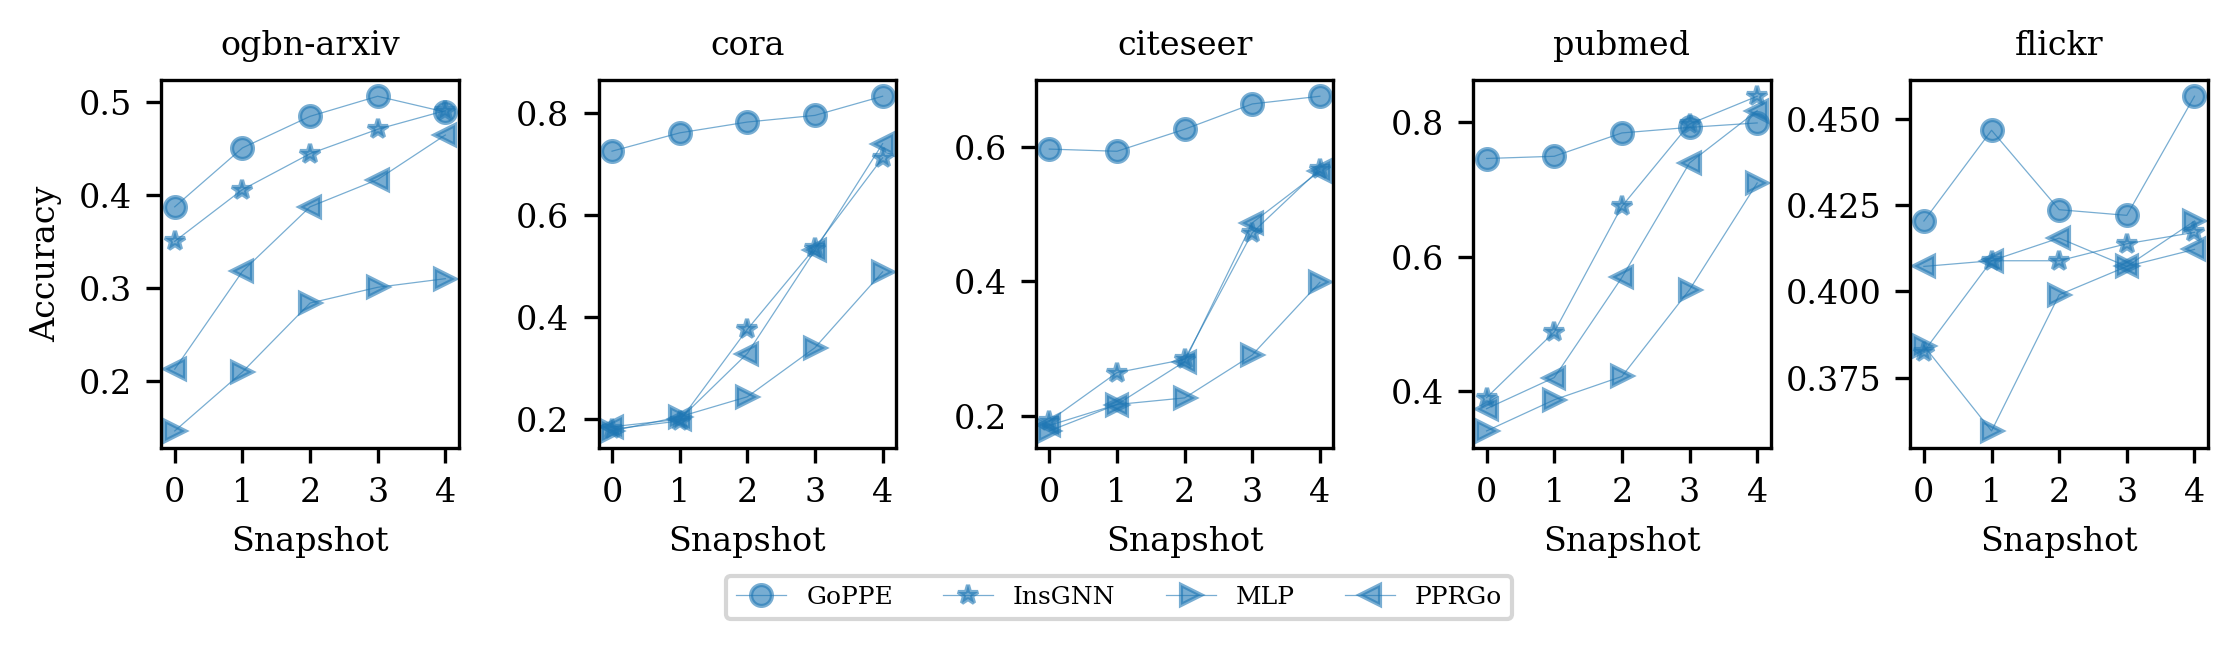

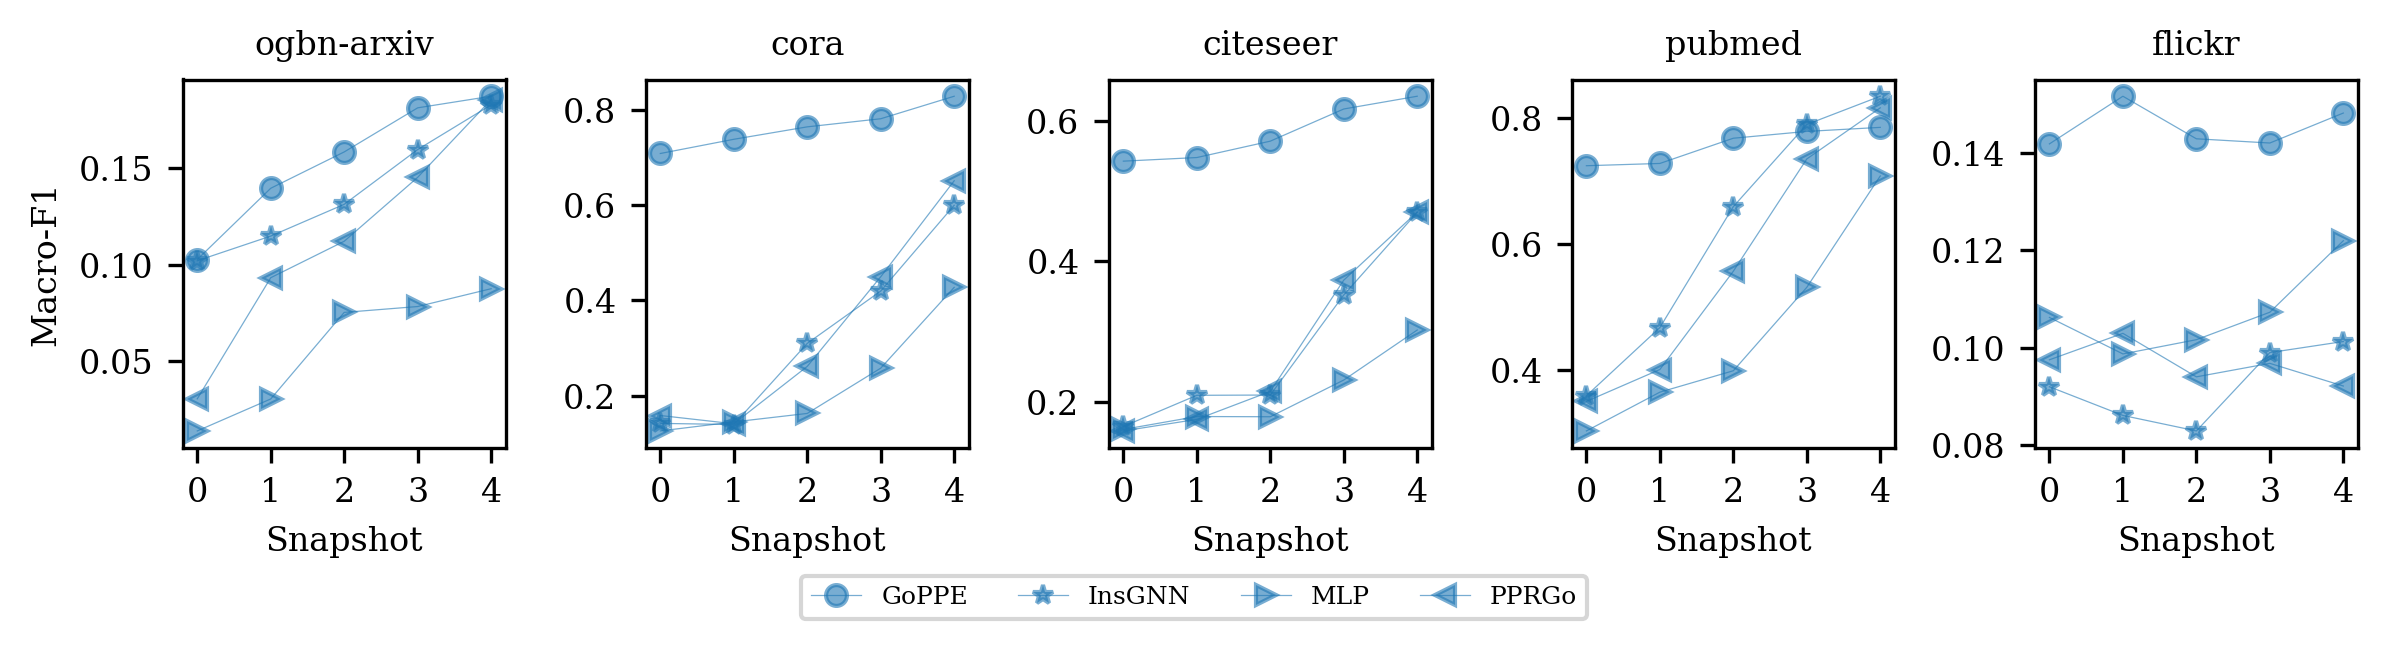

In [5]:
# additive noise experiments
version = 201 # 202/203for arxiv

plot_exp_list = [
    {
        "exp_name": f'exp-2-ogbn-arxiv-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'ogbn-arxiv'
        },    
    {
        "exp_name": f'exp-2-cora-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'cora'
        },
    {
        "exp_name": f'exp-2-citeseer-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'citeseer'
        },
    {
        "exp_name": f'exp-2-pubmed-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'pubmed'
        },
    {
        "exp_name": f'exp-2-flickr-debug-{version}', 
        "clf_alpha": 0.30, 
        "graph": 'flickr'
        },
]

res_dir = f'/home/xingzguo/git_project/DynMixer/results/exp-2-v{version}/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)


table_ppr_avg_record = []
fig, axes = plt.subplots(1,5, figsize = (7.5, 2.0), dpi=300)
axes = np.array([axes])
axes = axes.flatten()
for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    _df_all_exp_res = get_df_res(local_res_path, exp_name, clf_alpha)
    # print('df_all_exp_res.shape', df_all_exp_res.shape)
    result_summary_dict = get_exp_plot_data(_df_all_exp_res)

    plot_kwargs_dict = {}
    agg_res = {}
    for _record in result_summary_dict['accuracy']:
        plot_kwargs_dict[_record['model']] = _record['plt_plot_kwargs']
        if _record['model'] not in agg_res:
            agg_res[_record['model']] = []
        agg_res[_record['model']].append(_record['data'])
        
    for model, acc in agg_res.items():
        if model == 'DynPPE':
            continue 
        # plot acc
        ax = axes[ax_i]
        if ax_i == 0:
            ax.set_ylabel('Accuracy')
        ax.set_xlabel('Snapshot')
        # ax.set_title(f'Accuracy (dataset:{dataset_name})')
        # ax.set_title(f'Accuracy')
        ax.set_title(graph_name)
        ax.plot(np.mean(acc, axis = 0), **plot_kwargs_dict[model])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        table_ppr_avg_record.append(
            {
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":model,
                "accuracy-mean": np.mean(acc),
                "accuracy-std": np.std(acc),
            }
        )


handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=6, loc='upper center', bbox_to_anchor=(0.5, 0.05), prop={'size': 6})
fig.tight_layout()
fig_path = os_join(res_dir, f'fig-clf-exp-1-all-acc.pdf')
print('save to ', fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')

fig, axes = plt.subplots(1,5, figsize = (8, 2.0), dpi=300)
axes = np.array([axes])
axes = axes.flatten()
for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    _df_all_exp_res = get_df_res(local_res_path, exp_name, clf_alpha)
    # print('df_all_exp_res.shape', df_all_exp_res.shape)
    result_summary_dict = get_exp_plot_data(_df_all_exp_res)

    plot_kwargs_dict = {}
    agg_res = {}
    for _record in result_summary_dict['macro-f1']:
        plot_kwargs_dict[_record['model']] = _record['plt_plot_kwargs']
        if _record['model'] not in agg_res:
            agg_res[_record['model']] = []
        agg_res[_record['model']].append(_record['data'])
        
    for model, f1 in agg_res.items():
        # plot acc
        if model == 'DynPPE':
            continue 

        ax = axes[ax_i]
        if ax_i == 0:
            ax.set_ylabel('Macro-F1')

        ax.set_xlabel('Snapshot')
        # ax.set_title(f'Accuracy (dataset:{dataset_name})')
        # ax.set_title(f'Accuracy')
        ax.set_title(graph_name)
        ax.plot(np.mean(f1, axis = 0), **plot_kwargs_dict[model])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))


handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=6, loc='upper center', bbox_to_anchor=(0.5, 0.05), prop={'size': 6})
fig.tight_layout()
fig_path = os_join(res_dir, f'fig-clf-exp-1-all-macro-f1.pdf')
print('save to ', fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')



### plot tables exp2

In [125]:
df_all_ppr_res = pd.DataFrame.from_records(table_ppr_avg_record)

select_cols = ['dataset', 'ppr-algo', 'accuracy-mean', 'accuracy-std'] #'l1-err-mean',
df_select_ppr_res = df_all_ppr_res[df_all_ppr_res["ppr-algo"]!= "mixrank-random_sample"][select_cols]

# df_ppr_time = df_select_ppr_res.set_index(['increment', 'ppr-algo'])
df_acc_mean = pd.pivot_table(df_select_ppr_res, index = ['ppr-algo'], columns=['dataset'], values= "accuracy-mean").reset_index()
df_acc_std = pd.pivot_table(df_select_ppr_res, index = ['ppr-algo'], columns=['dataset'], values= "accuracy-std").reset_index()

col_reorder = ["ppr-algo", "cora", "citeseer", "pubmed", "ogbn-arxiv", "flickr"]
df_acc_mean = df_acc_mean[col_reorder].sort_values(['ppr-algo', ], ascending = [True]).set_index("ppr-algo", drop=True)
# row_reorder = ["gaussian", "mlp", "pprgo-ista","mixrank-all","ppe-ista", "goppe-ista" ]
row_reorder = [ "MLP", "PPRGo","InsGNN","DynPPE", "GoPPE" ]

df_acc_mean = df_acc_mean.reindex(row_reorder)
print(df_acc_mean.to_latex(float_format="%.4f"))

# df_acc_std

\begin{tabular}{lrrrrr}
\toprule
dataset &   cora &  citeseer &  pubmed &  ogbn-arxiv &  flickr \\
ppr-algo &        &           &         &             &         \\
\midrule
MLP      & 0.2905 &    0.2624 &  0.4816 &      0.2503 &  0.3941 \\
PPRGo    & 0.3967 &    0.3471 &  0.5837 &      0.3599 &  0.4102 \\
InsGNN   & 0.4000 &    0.3562 &  0.6378 &      0.4324 &  0.4062 \\
DynPPE   &    NaN &       NaN &     NaN &         NaN &     NaN \\
GoPPE    & 0.7797 &    0.6307 &  0.7745 &      0.4636 &  0.4338 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_18470/2263705535.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_acc_mean.to_latex(float_format="%.4f"))


#### 3.2  plot average performance table acorss snapshots

In [10]:
# df_acc = pd.DataFrame.from_records(result_summary_dict['accuracy']).set_index('model', drop=True)
# df_macro_f1 = pd.DataFrame.from_records(result_summary_dict['macro-f1']).set_index('model', drop=True)

# def rank_by_mean(df, metric):
#     mean_metric_str = f'{metric}-mean'
#     df[mean_metric_str] = df['data'].apply(np.mean)
#     df = df.sort_values(mean_metric_str, ascending=False)
#     return df[[mean_metric_str]]

# if not os.path.exists(res_dir):
#     os.makedirs(res_dir)
# tab_path = os_join(res_dir, f'tab-clf-res.tex')

# print('make sure file=f is uncommented!')
# with open(tab_path, 'w') as f:
#     df_acc_sorted = rank_by_mean(df_acc, 'accuracy')
#     print(
#         df_acc_sorted.style.format(precision=4).to_latex(
#             column_format="lr", position="ht", position_float="centering",
#             hrules=True, 
#             label=f"tab:clf-res-{dataset_name}-avg-acc", 
#             caption=f"Avg. Accuracy ({dataset_name})",
#             multirow_align="t", multicol_align="r"
#             ),
#         file =f
#         )

#     df_macro_f1_sorted = rank_by_mean(df_macro_f1, 'macro-f1' )
#     print(
#         df_macro_f1_sorted.style.format(precision=4).to_latex(
#             column_format="lr", position="ht", position_float="centering",
#             hrules=True, 
#             label=f"tab:clf-res-{dataset_name}-avg-macro-f1", 
#             caption=f"Avg. Macro-F1 ({dataset_name})",
#             multirow_align="t", multicol_align="r"
#             ),
#         file =f
#         )

# print(df_macro_f1_sorted.style.to_latex(float_format='%.4f'))
# pd.concat((df_acc_sorted, df_macro_f1_sorted), axis = 1)

### 3.2 plot PPR benchmark 

In [11]:

def give_ppr_plot_kwargs(ppv_res:PPVResult, is_incrmt_ppr:bool):
    """ set color/shape for plotting
    
    """
    
    ppr_algo = ppv_res.ppr_algo
    ppr_alpha = ppv_res.ppr_alpha
    # is_dyn = ppv_res.is

    # ppr-algo
    line_color_dict = {
        'ista': colors_palette['tab:blue'], 
        'power_iteration':colors_palette['tab:red'],
        'forward_push':colors_palette['tab:pink'],
    }
    
    # agg method
    marker_dict = {
        # 'ppe': '1',
        'default': 'o',
        'incre': '>',
        # 'gaussian': 's',
        # 'pprgo': '<',
        # 'mixrank':'*',
        # 'polyrank': 'x',
    }

    
    # mixrank/polyrank variants
    markerface_color_dict = {
        #random_sample high_ppr low_ppr high_low_ppr all
        'default': colors_palette['tab:blue'], 
        # 'linear':colors_palette['tab:orange'],
        # 'softmax':colors_palette['tab:green'],
        # 'poly':colors_palette['tab:red'],
        # 'high_low_ppr': colors_palette['tab:purple'],
        # 'high_ppr':colors_palette['tab:brown'],
        # 'low_ppr':colors_palette['tab:pink'],
        # 'random_sample': colors_palette['tab:gray'],
    }
    
    # emphsize baseline pprog/mlp
    linewidth = 0.3
    alpha=0.8
    
    label_map = {
        "forward_push": "Push",
        "ista": "GoPPE",
        "power_iteration": "PweIter",
    }
    
    line_color = line_color_dict[ppr_algo]
    markerfacecolor = line_color
    marker_shape = marker_dict['default'] if not is_incrmt_ppr else marker_dict['incre']
    label = f"{label_map[ppr_algo]}-D" if is_incrmt_ppr else f"{label_map[ppr_algo]}-S"
    # label = f"{ppr_algo}"


    # print(aggregate_type, line_color, markerfacecolor)

    return {
        'color' : line_color,
        'marker' : marker_shape,
        'markerfacecolor': markerfacecolor,
        'markeredgecolor': markerfacecolor,
        'linestyle' : '-',
        'linewidth' : linewidth,
        'markersize' : 5,
        'label':label,
        'alpha': alpha,
    }


def get_ppr_benchmark_stats(df_all_exp_res:pd.DataFrame):
    """ re-org ppr-benchmark cache for table and plot.
    
    """
    ppr_benchmark_res_dict:List[Dict[str, PPVResult]] = df_all_exp_res['results']
    
    # print(len(ppr_benchmark_res_dict.tolist()))
    # print(ppr_benchmark_res_dict[0])
    
    return ppr_benchmark_res_dict.tolist()



def get_ppr_err_time_plot_data(ppr_benchmark_res_dict_list, ppr_algo_gold, is_incrmt_ppr):
    avg_ppr_l1_err_per_snapshot = {}
    avg_update_time_ppr_update = {}
    total_ppr_update_ops  = {}
    plot_dict_list = []
    
    if len(ppr_benchmark_res_dict_list) == 0:
        return plot_dict_list
    for i in range(len(ppr_benchmark_res_dict_list)):
        ppr_benchmark_res_dict = ppr_benchmark_res_dict_list[i]
        for ppr_algo_label in ppr_benchmark_res_dict.keys():
            ppv_result : PPVResult = ppr_benchmark_res_dict[ppr_algo_label]
            # print('-->', ppv_result.ppr_algo, ppv_result.ppr_alpha)        
            # print(ppv_result.ppr_algo_param_dict)
            # print(ppv_result.ppr_l1_err_per_snapshot)
            # print(ppv_result.ppr_l1_norm_per_snapshot)
            # print(ppv_result.update_time_ppr_update)
            if ppr_algo_label not in avg_ppr_l1_err_per_snapshot.keys():
                avg_ppr_l1_err_per_snapshot[ppr_algo_label] = []
                avg_update_time_ppr_update[ppr_algo_label] = []
                total_ppr_update_ops[ppr_algo_label] = []
            avg_ppr_l1_err_per_snapshot[ppr_algo_label].append(ppv_result.ppr_l1_err_per_snapshot)
            avg_update_time_ppr_update[ppr_algo_label].append(ppv_result.update_time_ppr_update)
            total_ppr_update_ops[ppr_algo_label].append(ppv_result.update_ops_ppr_update)

    ppr_benchmark_res_dict = ppr_benchmark_res_dict_list[0]
    for ppr_algo_label in ppr_benchmark_res_dict_list[0].keys():
        ppv_result : PPVResult = ppr_benchmark_res_dict[ppr_algo_label]
        _avg_ppr_l1_err_per_snapshot = np.mean(avg_ppr_l1_err_per_snapshot[ppr_algo_label], axis = 0)
        _avg_update_time_ppr_update = np.mean(avg_update_time_ppr_update[ppr_algo_label], axis = 0)
        # total_ppr_update_ops
        _total_ppr_ops_updates = total_ppr_update_ops[ppr_algo_label]
    
        # "power_iter_ops": np.uint64(0),
        # "local_push_pos_push": np.uint64(0),
        # "local_push_neg_push": np.uint64(0),
        # "ista_ops": np.uint64(0),

        plot_kwargs = give_ppr_plot_kwargs(ppv_result, is_incrmt_ppr)
        
        print(ppr_algo_label, _avg_ppr_l1_err_per_snapshot)
        plot_dict_list.append(
            {
                'ppr_algo_label':ppr_algo_label,
                'ppr_l1_err': _avg_ppr_l1_err_per_snapshot,
                'ppr_cpu_time': _avg_update_time_ppr_update,
                'ppr_ops':_total_ppr_ops_updates,
                'plot_kwargs': plot_kwargs
            }
        )

    return plot_dict_list

def get_ppr_benchmark_df(local_res_path, exp_name, clf_alpha):
    local_benchmark_exp_res_path = os_join(local_res_path,exp_name, 'df-exp-ppr-benchmark-result-*.pkl' )
    res_files_benchmark = glob.glob(local_benchmark_exp_res_path)
    df_list_benchmark:List[pd.DataFrame] = []
    for i, file_path in enumerate(res_files_benchmark):
        # print(i,file_path)
        df_list_benchmark.append(pd.read_pickle(file_path))
    df_all_exp_res_benchmark = pd.concat(df_list_benchmark, ignore_index = True)

    # for example, only show alpha=0.15 0.3
    df_all_exp_res_benchmark = df_all_exp_res_benchmark[df_all_exp_res_benchmark['alpha'] == clf_alpha]

    df_all_exp_res_benchmark_static = df_all_exp_res_benchmark[df_all_exp_res_benchmark['use_incrmt_ppr'] == False]
    df_all_exp_res_benchmark_increment = df_all_exp_res_benchmark[df_all_exp_res_benchmark['use_incrmt_ppr'] == True]

    print('final static picked num:', df_all_exp_res_benchmark_static.shape[0])
    print('final dynamic picked num:', df_all_exp_res_benchmark_increment.shape[0])

    ppr_benchmark_res_dict_list_static = get_ppr_benchmark_stats(df_all_exp_res_benchmark_static)
    ppr_benchmark_res_dict_list_increment = get_ppr_benchmark_stats(df_all_exp_res_benchmark_increment)
    return  ppr_benchmark_res_dict_list_static, ppr_benchmark_res_dict_list_increment


### Single acc plot

final static picked num: 3
final dynamic picked num: 3
power-iter-golden [0. 0. 0. 0. 0.]
push [4.30186953e-08 4.31234160e-08 4.32290757e-08 4.32805173e-08
 4.33463420e-08]
ista [2.83600367e-08 2.83600367e-08 2.83600367e-08 2.83600367e-08
 2.83600368e-08]
power-iter-golden [0. 0. 0. 0. 0.]
push [4.30186953e-08 4.33140618e-08 4.33807568e-08 4.34672516e-08
 4.35892818e-08]
ista [2.83600367e-08 2.79463428e-08 2.79467806e-08 2.79466207e-08
 2.79460844e-08]
[[{'power_iter_ops': 28682421768, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 35853059088, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 43023696408, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 50194333728, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 57364843536, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}], [{'power_iter_ops': 28682421768, 'local_

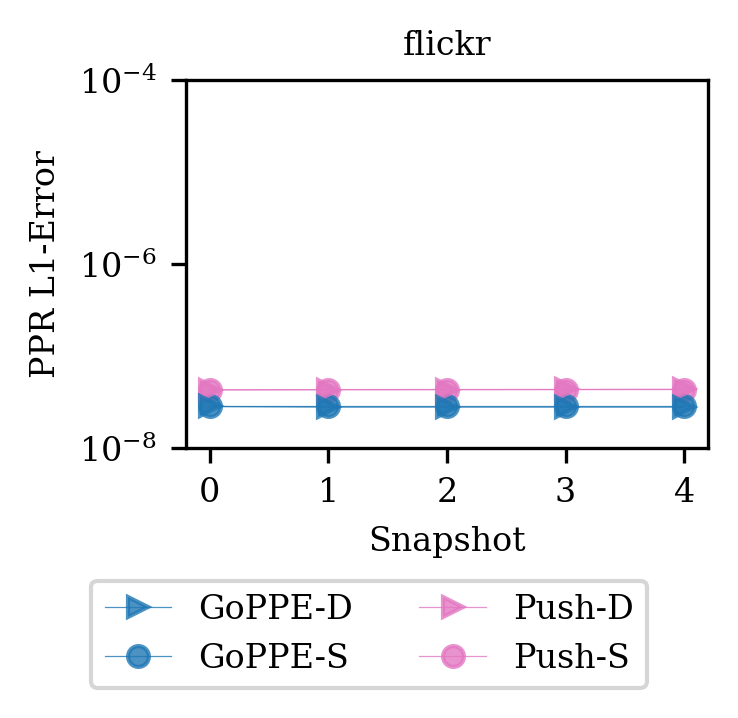

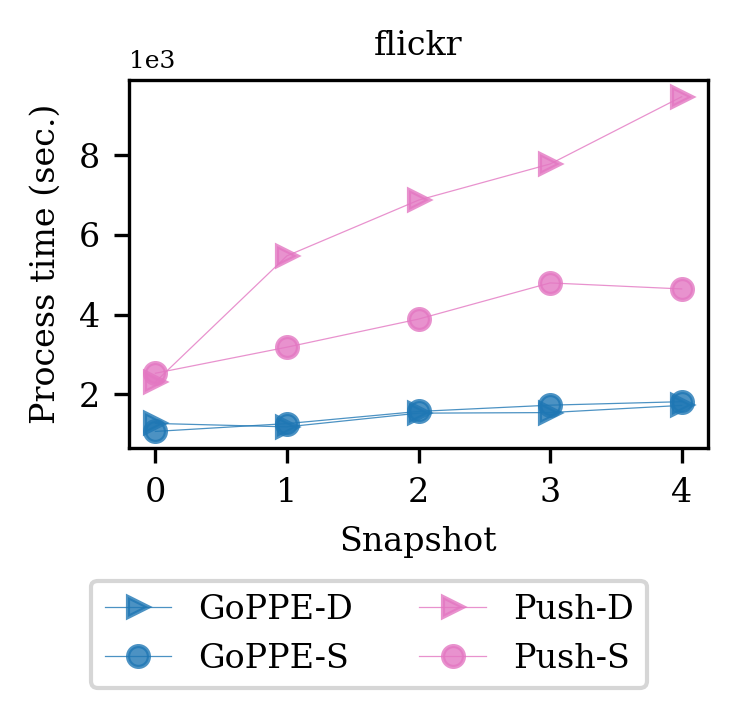

In [30]:
version = 4 #10 # 4  # 12
plot_exp_list = [
    # {
    #     "exp_name": f'exp-3-ogbn-arxiv-debug-{version}', 
    #     "clf_alpha": 0.15, 
    #     "graph": 'ogbn-arxiv'
    #     },    
    # {
    #     "exp_name": f'exp-3-cora-debug-{version}', 
    #     "clf_alpha": 0.15, 
    #     "graph": 'cora'
    #     },
    # {
    #     "exp_name": f'exp-3-citeseer-debug-{version}', 
    #     "clf_alpha": 0.15, 
    #     "graph": 'citeseer'
    #     },
    # {
    #     "exp_name": f'exp-3-pubmed-debug-{version}', 
    #     "clf_alpha": 0.15, 
    #     "graph": 'pubmed'
    #     },
    {
        "exp_name": f'exp-3-flickr-debug-{version}', 
        "clf_alpha": 0.30, 
        "graph": 'flickr'
        },
]
res_dir = f'/home/xingzguo/git_project/DynMixer/results/exp-3-v{version}/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
    

fig, axes = plt.subplots(1,1, figsize = (2.5, 2), dpi=300)
axes = np.array([axes])
axes = axes.flatten()

fig_time, axes_time = plt.subplots(1,1, figsize = (2.5, 2), dpi=300)
axes_time = np.array([axes_time])
axes_time = axes_time.flatten()


ppr_algo_gold = "power-iter-golden"

table_ppr_avg_record = []



for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    ppr_benchmark_res_dict_list_static, ppr_benchmark_res_dict_list_increment = get_ppr_benchmark_df(local_res_path, exp_name, clf_alpha)
    
    
    plot_dict_list_static = get_ppr_err_time_plot_data(
        ppr_benchmark_res_dict_list_static, 
        ppr_algo_gold,
        is_incrmt_ppr = False
        )
    plot_dict_list_increment = get_ppr_err_time_plot_data(
        ppr_benchmark_res_dict_list_increment, 
        ppr_algo_gold,
        is_incrmt_ppr = True
        )
        
    for plot_entry in plot_dict_list_static:
        ppr_algo_label = plot_entry['ppr_algo_label']
        _avg_ppr_l1_err_per_snapshot = plot_entry['ppr_l1_err']
        _avg_update_time_ppr_update = plot_entry['ppr_cpu_time']
        plot_kwargs = plot_entry['plot_kwargs']
        
        table_ppr_avg_record.append(
            {
                "increment": False,
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":ppr_algo_label,
                "l1-err-mean": np.mean(_avg_ppr_l1_err_per_snapshot),
                "cpu-time-total": np.sum(_avg_update_time_ppr_update),
                "ppr-ops": plot_entry['ppr_ops'],
            }
        )
        
        print(plot_entry['ppr_ops'])
        
        ax = axes[ax_i]
        ax_time = axes_time[ax_i]
        ax.set_title(graph_name)
        ax_time.set_title(graph_name)
        if ax_i == 0:
            ax.set_ylabel('PPR L1-Error') #avg
            ax_time.set_ylabel('Process time (sec.)')
        
        # if ppr_algo_label == 'ista':
        #     print('skip ista')
        
        if ppr_algo_label != ppr_algo_gold:
            ax.plot(_avg_ppr_l1_err_per_snapshot, **plot_kwargs)
            ax_time.plot(_avg_update_time_ppr_update, **plot_kwargs)
            # ax.set_title('PPR L1-Error') #avg
            ax.set_xlabel('Snapshot')
        else:
            print(f'skip1 {ppr_algo_label}')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_time.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.get_offset_text().set_fontsize(6)
    ax_time.yaxis.get_offset_text().set_fontsize(6)

    # only plot push -incremental
    for plot_entry in plot_dict_list_increment:
        ppr_algo_label = plot_entry['ppr_algo_label']
        # if ppr_algo_label not in ('push')  :
        if ppr_algo_label not in ('push', 'ista')  :
            print(f'skip {ppr_algo_label} since it does not have incremental solution')
            continue
        _avg_ppr_l1_err_per_snapshot = plot_entry['ppr_l1_err']
        _avg_update_time_ppr_update = plot_entry['ppr_cpu_time']
        plot_kwargs = plot_entry['plot_kwargs']
        
        table_ppr_avg_record.append(
            {
                "increment": True,
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":ppr_algo_label,
                "l1-err-mean": np.mean(_avg_ppr_l1_err_per_snapshot),
                "cpu-time-total": np.sum(_avg_update_time_ppr_update),
                "ppr-ops": plot_entry['ppr_ops'],
            }
        )
        print(plot_entry['ppr_ops'])

        ax = axes[ax_i]
        # ax.set_yscale('log')
        ax_time = axes_time[ax_i]
        ax_time.ticklabel_format(axis = 'y', style ='sci', scilimits = (0,1))
        # ax.ticklabel_format(axis = 'y', style ='sci', scilimits = (-1,1))
        ax.set_yscale('log')
        ax.set_ylim((1e-8, 1e-4))
        
        if ppr_algo_label != ppr_algo_gold:
            ax.plot(_avg_ppr_l1_err_per_snapshot, **plot_kwargs)
            ax_time.plot(_avg_update_time_ppr_update, **plot_kwargs)
            ax_time.set_xlabel('Snapshot')
        else:
            print(f'skip3 {ppr_algo_label}')

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=2, loc='upper center', bbox_to_anchor=(0.5, 0.05))
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0))

fig.tight_layout()
fig_name = f"fig-ppr-l1-err-all-single-{graph_name}.pdf"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
fig_path = os_join(res_dir, fig_name)
print(fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')


handles, labels = ax_time.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig_time.legend(handles, labels, ncols=2, loc='upper center', bbox_to_anchor=(0.5, 0.05))
# fig_time.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 1.0))
fig_time.tight_layout()
fig_name = f"fig-ppr-time-all-single-{graph_name}.pdf"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
fig_path = os_join(res_dir, fig_name)
print(fig_path)
fig_time.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')


## all acc plot

final static picked num: 3
final dynamic picked num: 3
power-iter-golden [0. 0. 0. 0. 0.]
push [4.64378992e-06 4.74089837e-06 4.79602874e-06 4.79709518e-06
 4.80267141e-06]
ista [5.92279979e-06 6.05176284e-06 6.13075892e-06 6.14705951e-06
 6.16484097e-06]
power-iter-golden [0. 0. 0. 0. 0.]
push [4.64378992e-06 4.84213397e-06 4.90609470e-06 4.91332262e-06
 4.92104681e-06]
ista [5.92279979e-06 5.95004096e-06 6.02720189e-06 6.04261780e-06
 6.06015169e-06]
[[{'power_iter_ops': 127601138000, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 159501422500, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 191401707000, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 223301991500, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}, {'power_iter_ops': 255202055580, 'local_push_pos_push': 0, 'local_push_neg_push': 0, 'ista_ops': 0}], [{'power_iter_ops': 127601138000, '

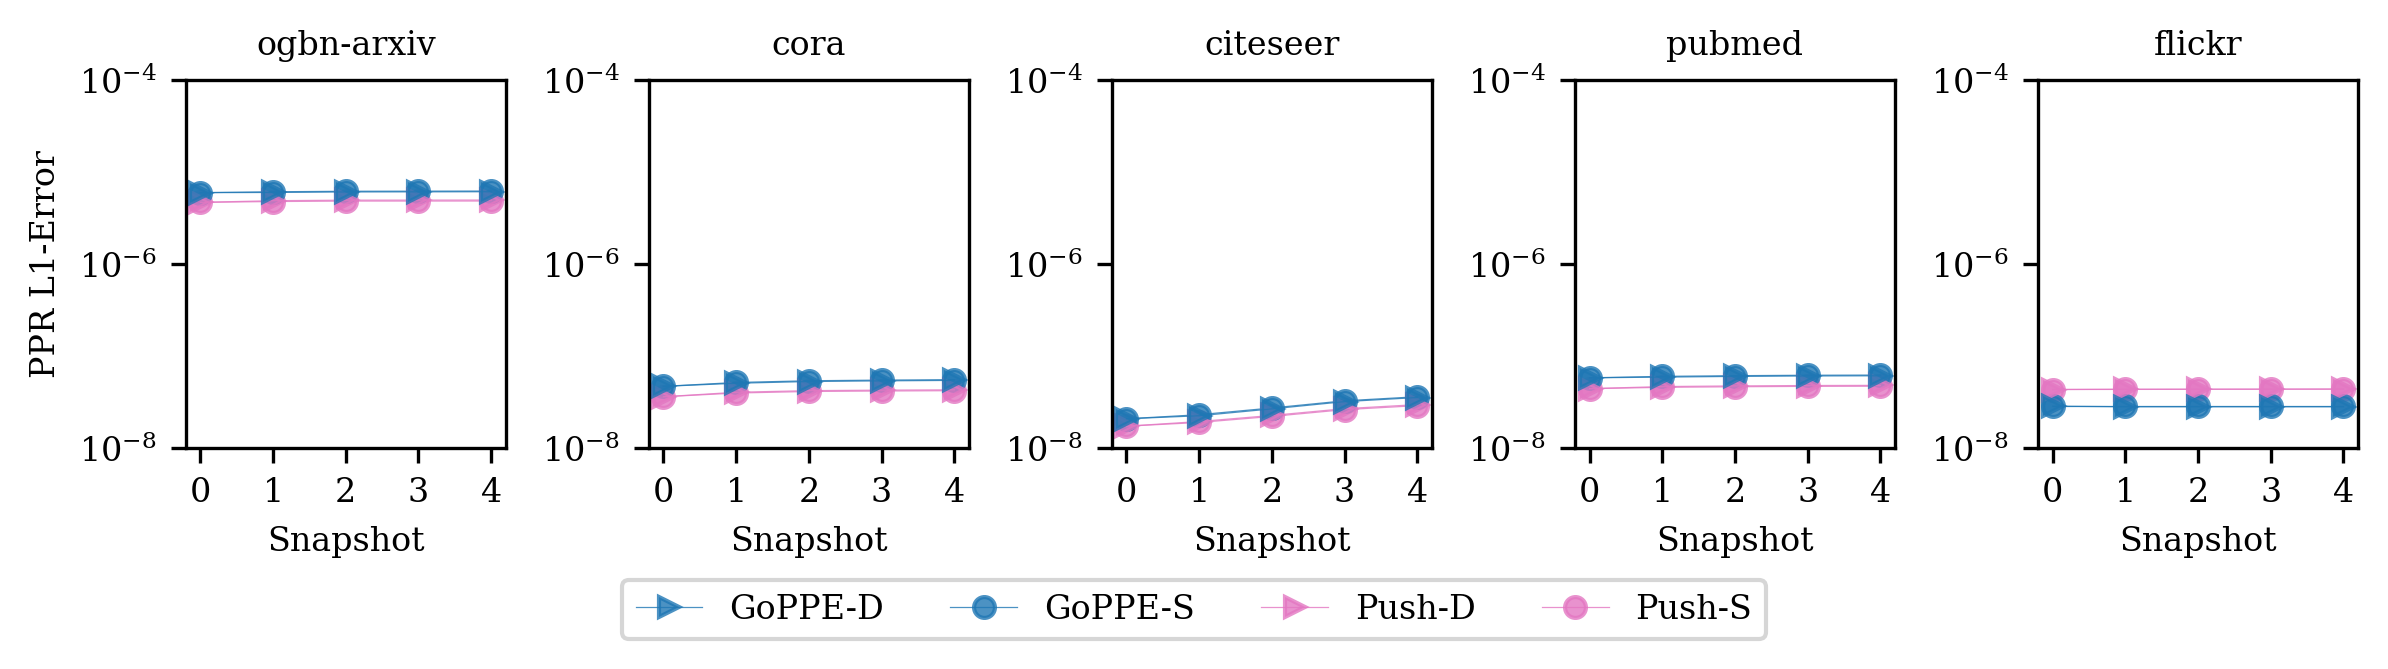

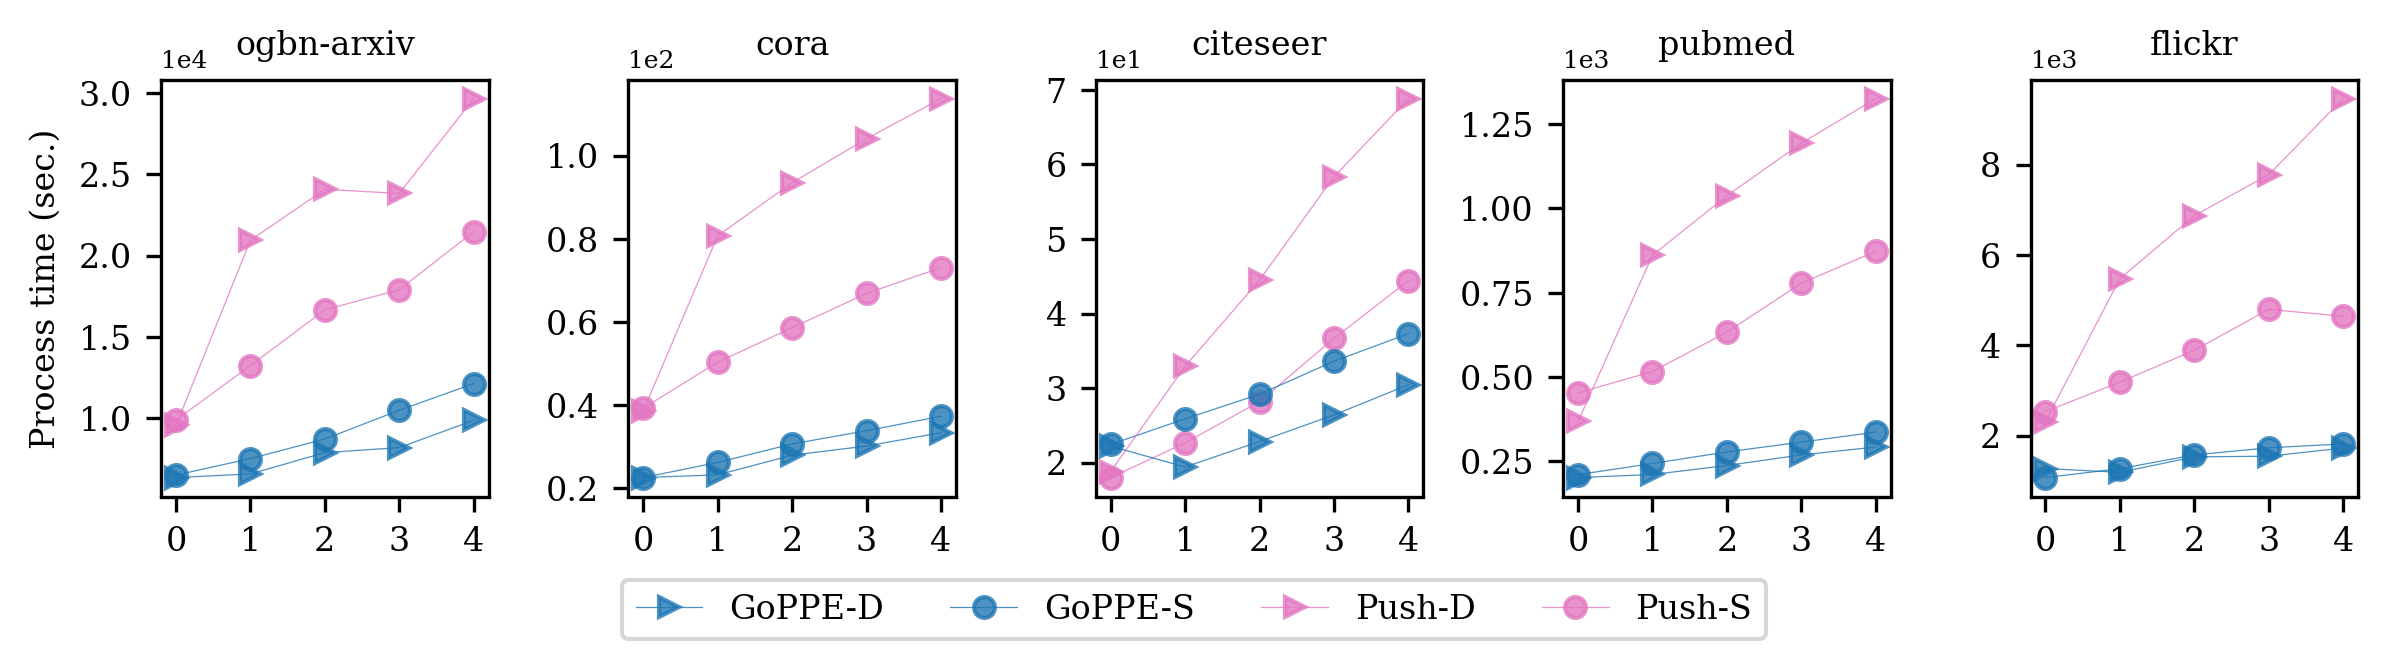

In [31]:
version = 4  #10 # 4:  12
# 5 is the pangu local run of pubmed

# 12: use all 1e-8 excpet arxiv 
# 10: use all 1e-6
plot_exp_list = [
    {
        "exp_name": f'exp-3-ogbn-arxiv-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'ogbn-arxiv'
        },    
    {
        "exp_name": f'exp-3-cora-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'cora'
        },
    {
        "exp_name": f'exp-3-citeseer-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'citeseer'
        },
    {
        "exp_name": f'exp-3-pubmed-debug-{version}', 
        "clf_alpha": 0.15, 
        "graph": 'pubmed'
        },
    {
        "exp_name": f'exp-3-flickr-debug-{version}', 
        "clf_alpha": 0.30, 
        "graph": 'flickr'
        },
]
res_dir = f'/home/xingzguo/git_project/DynMixer/results/exp-3-v{version}/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
    

fig, axes = plt.subplots(1,5, figsize = (8, 2.0), dpi=300)
axes = np.array([axes])
axes = axes.flatten()

fig_time, axes_time = plt.subplots(1,5, figsize = (8, 2.0), dpi=300)
axes_time = np.array([axes_time])
axes_time = axes_time.flatten()


ppr_algo_gold = "power-iter-golden"

table_ppr_avg_record = []



for ax_i, plot_exp_record in enumerate(plot_exp_list):
    exp_name = plot_exp_record['exp_name']
    clf_alpha = plot_exp_record['clf_alpha']
    graph_name = plot_exp_record['graph']
    ppr_benchmark_res_dict_list_static, ppr_benchmark_res_dict_list_increment = get_ppr_benchmark_df(local_res_path, exp_name, clf_alpha)
    
    
    plot_dict_list_static = get_ppr_err_time_plot_data(
        ppr_benchmark_res_dict_list_static, 
        ppr_algo_gold,
        is_incrmt_ppr = False
        )
    plot_dict_list_increment = get_ppr_err_time_plot_data(
        ppr_benchmark_res_dict_list_increment, 
        ppr_algo_gold,
        is_incrmt_ppr = True
        )
        
    for plot_entry in plot_dict_list_static:
        ppr_algo_label = plot_entry['ppr_algo_label']
        _avg_ppr_l1_err_per_snapshot = plot_entry['ppr_l1_err']
        _avg_update_time_ppr_update = plot_entry['ppr_cpu_time']
        plot_kwargs = plot_entry['plot_kwargs']
        
        table_ppr_avg_record.append(
            {
                "increment": False,
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":ppr_algo_label,
                "l1-err-mean": np.mean(_avg_ppr_l1_err_per_snapshot),
                "cpu-time-total": np.sum(_avg_update_time_ppr_update),
                "ppr-ops": plot_entry['ppr_ops'],
            }
        )
        
        print(plot_entry['ppr_ops'])
        
        ax = axes[ax_i]
        ax_time = axes_time[ax_i]
        ax.set_title(graph_name)
        ax_time.set_title(graph_name)
        if ax_i == 0:
            ax.set_ylabel('PPR L1-Error') #avg
            ax_time.set_ylabel('Process time (sec.)')
        
        # if ppr_algo_label == 'ista':
        #     print('skip ista')
        
        if ppr_algo_label != ppr_algo_gold:
            ax.plot(_avg_ppr_l1_err_per_snapshot, **plot_kwargs)
            ax_time.plot(_avg_update_time_ppr_update, **plot_kwargs)
            # ax.set_title('PPR L1-Error') #avg
            ax.set_xlabel('Snapshot')
        else:
            print(f'skip1 {ppr_algo_label}')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_time.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.get_offset_text().set_fontsize(6)
    ax_time.yaxis.get_offset_text().set_fontsize(6)

    # only plot push -incremental
    for plot_entry in plot_dict_list_increment:
        ppr_algo_label = plot_entry['ppr_algo_label']
        # if ppr_algo_label not in ('push')  :
        if ppr_algo_label not in ('push', 'ista')  :
            print(f'skip {ppr_algo_label} since it does not have incremental solution')
            continue
        _avg_ppr_l1_err_per_snapshot = plot_entry['ppr_l1_err']
        _avg_update_time_ppr_update = plot_entry['ppr_cpu_time']
        plot_kwargs = plot_entry['plot_kwargs']
        
        table_ppr_avg_record.append(
            {
                "increment": True,
                "dataset":graph_name,
                "exp-name":exp_name,
                "alpha":clf_alpha,
                "ppr-algo":ppr_algo_label,
                "l1-err-mean": np.mean(_avg_ppr_l1_err_per_snapshot),
                "cpu-time-total": np.sum(_avg_update_time_ppr_update),
                "ppr-ops": plot_entry['ppr_ops'],
            }
        )
        print(plot_entry['ppr_ops'])

        ax = axes[ax_i]
        # ax.set_yscale('log')
        ax_time = axes_time[ax_i]
        ax_time.ticklabel_format(axis = 'y', style ='sci', scilimits = (0,1))
        # ax.ticklabel_format(axis = 'y', style ='sci', scilimits = (-1,1))
        ax.set_yscale('log')
        ax.set_ylim((1e-8, 1e-4))
        if ppr_algo_label != ppr_algo_gold:
            ax.plot(_avg_ppr_l1_err_per_snapshot, **plot_kwargs)
            ax_time.plot(_avg_update_time_ppr_update, **plot_kwargs)
            ax.set_xlabel('Snapshot')
        else:
            print(f'skip3 {ppr_algo_label}')

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.05))
fig.tight_layout()
fig_name = f"fig-ppr-l1-err-all.pdf"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
fig_path = os_join(res_dir, fig_name)
print(fig_path)
fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')


handles, labels = ax_time.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig_time.legend(handles, labels, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.05))
fig_time.tight_layout()
fig_name = f"fig-ppr-time-all.pdf"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
fig_path = os_join(res_dir, fig_name)
print(fig_path)
fig_time.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')


### produce table for speed

In [32]:
df_all_ppr_res = pd.DataFrame.from_records(table_ppr_avg_record)
select_cols = ['increment', 'dataset', 'ppr-algo', 'l1-err-mean', 'cpu-time-total'] #'l1-err-mean',
df_select_ppr_res = df_all_ppr_res[df_all_ppr_res["ppr-algo"]!= ppr_algo_gold][select_cols]

# df_ppr_time = df_select_ppr_res.set_index(['increment', 'ppr-algo'])
df_ppr_time = pd.pivot_table(df_select_ppr_res, index = ['increment', 'ppr-algo'], columns=['dataset'], values= "cpu-time-total").reset_index()
df_ppr_l1_err = pd.pivot_table(df_select_ppr_res, index = ['increment', 'ppr-algo'], columns=['dataset'], values= "l1-err-mean").reset_index()

col_reorder = ["ppr-algo", "increment", "cora", "citeseer", "pubmed", "ogbn-arxiv", "flickr"]
# col_reorder = ["ppr-algo", "increment", "cora", "citeseer", "pubmed", "flickr"]
df_ppr_time = df_ppr_time[col_reorder].sort_values(['increment', 'ppr-algo', ], ascending = [True, False])
df_ppr_l1_err = df_ppr_l1_err[col_reorder].sort_values(['increment', 'ppr-algo', ], ascending = [True, False])
# df_ppr_l1_err.reset_index()
print(df_ppr_time.to_latex(float_format="%.2f", index=False))
print(df_ppr_l1_err.to_latex(float_format="%.2e", index=False))




\begin{tabular}{llrrrrr}
\toprule
ppr-algo &  increment &   cora &  citeseer &  pubmed &  ogbn-arxiv &   flickr \\
\midrule
    push &      False & 288.07 &    149.89 & 3254.14 &    79133.65 & 19035.70 \\
    ista &      False & 150.53 &    148.38 & 1376.25 &    45320.18 &  7452.47 \\
    push &       True & 430.57 &    223.41 & 4786.90 &   108048.49 & 31889.43 \\
    ista &       True & 137.21 &    121.29 & 1212.33 &    38830.99 &  7249.87 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrr}
\toprule
ppr-algo &  increment &     cora &  citeseer &   pubmed &  ogbn-arxiv &   flickr \\
\midrule
    push &      False & 3.99e-08 &  2.25e-08 & 4.57e-08 &    4.76e-06 & 4.32e-08 \\
    ista &      False & 5.22e-08 &  2.78e-08 & 6.03e-08 &    6.08e-06 & 2.84e-08 \\
    push &       True & 4.06e-08 &  2.30e-08 & 4.65e-08 &    4.85e-06 & 4.34e-08 \\
    ista &       True & 5.14e-08 &  2.73e-08 & 5.94e-08 &    6.00e-06 & 2.80e-08 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_8179/1124830054.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ppr_time.to_latex(float_format="%.2f", index=False))
/tmp/ipykernel_8179/1124830054.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ppr_l1_err.to_latex(float_format="%.2e", index=False))


## vis dataset

In [12]:
dataset = {}
dataset["cora"] = {
    "total_snapshot": 5,
    "total_num_nodes": 2708,
    "snapshot_interval": 660.0,
    "base_snapshot_t": 2638.0,
    "edge_event_timestamp_max": 5277.0,
    "edge_event_timestamp_min": 0.0,
    "node_feat_dim": 1433,
    "node_label_num_class": 7,
    "num_edge_events_per_snapshot": [5278, 1320, 1320, 1320, 1318],
    "num_node_per_snapshot": [1966, 2271, 2469, 2613, 2708],
    "num_node_feature_events_per_snapshot": [1966, 305, 198, 144, 95],
    "num_node_label_events_per_snapshot": [1966, 305, 198, 144, 95],
    "size": "small",
    "samples":1000,
}
dataset["citeseer"] = {
    "total_snapshot": 5,
    "total_num_nodes": 3279,
    "snapshot_interval": 569.0,
    "base_snapshot_t": 2275.0,
    "edge_event_timestamp_max": 4551.0,
    "edge_event_timestamp_min": 0.0,
    "node_feat_dim": 3703,
    "node_label_num_class": 6,
    "num_edge_events_per_snapshot": [4552, 1138, 1138, 1138, 1138],
    "num_node_per_snapshot": [2149, 2501, 2800, 3091, 3279],
    "num_node_feature_events_per_snapshot": [2147, 354, 297, 293, 188],
    "num_node_label_events_per_snapshot": [2147, 354, 297, 293, 188],
    "size": "small",
    "samples":1000,
}

dataset["pubmed"] = {
    "total_snapshot": 5,
    "total_num_nodes": 19717,
    "snapshot_interval": 5541.0,
    "base_snapshot_t": 22161.0,
    "edge_event_timestamp_max": 44323.0,
    "edge_event_timestamp_min": 0.0,
    "node_feat_dim": 500,
    "node_label_num_class": 3,
    "num_edge_events_per_snapshot": [44324, 11082, 11082, 11082, 11078],
    "num_node_per_snapshot": [13143, 15101, 16764, 18296, 19717],
    "num_node_feature_events_per_snapshot": [13142, 1958, 1664, 1532, 1421],
    "num_node_label_events_per_snapshot": [13142, 1958, 1664, 1532, 1421],
    "size": "small",
    "samples":1000,

}

dataset["flickr"] = {
    "total_snapshot": 5,
    "total_num_nodes": 89250,
    "snapshot_interval": 56235.0,
    "base_snapshot_t": 224938.0,
    "edge_event_timestamp_max": 449877.0,
    "edge_event_timestamp_min": 0.0,
    "node_feat_dim": 500,
    "node_label_num_class": 7,
    "num_edge_events_per_snapshot": [449878, 112470, 112470, 112470, 112468],
    "num_node_per_snapshot": [78455, 84741, 87862, 89062, 89250],
    "num_node_feature_events_per_snapshot": [78454, 6287, 3121, 1200, 188],
    "num_node_label_events_per_snapshot": [78454, 6287, 3121, 1200, 188],
    "size": "medium",
    "samples":2000,
}

dataset["ogbn-arvix"] = {
    "total_snapshot": 5,
    "total_num_nodes": 169343,
    "snapshot_interval": 144725.0,
    "base_snapshot_t": 578899.0,
    "edge_event_timestamp_max": 1157798.0,
    "edge_event_timestamp_min": 0.0,
    "node_feat_dim": 128,
    "node_label_num_class": 40,
    "num_edge_events_per_snapshot": [1157800, 289450, 289450, 289450, 289448],
    "num_node_per_snapshot": [120922, 133432, 144621, 157018, 169343],
    "num_node_feature_events_per_snapshot": [
        120922,
        12510,
        11189,
        12397,
        12325,
    ],
    "num_node_label_events_per_snapshot": [120922, 12510, 11189, 12397, 12325],
    "size": "medium",
    "samples":3000,

}

records = []
for dataset_name, _rec in dataset.items():
    _rec["dataset_name"] = dataset_name
    records.append(_rec)

df_dataset_raw = pd.DataFrame.from_records(records).set_index("dataset_name")
df_dataset_stats = df_dataset_raw[
    [
        "size",
        "total_num_nodes",
        "edge_event_timestamp_max",
        "total_snapshot",
        "samples",
        "node_feat_dim",
        "node_label_num_class",
    ]
]
df_dataset_stats = df_dataset_stats.astype({"edge_event_timestamp_max": int})
df_dataset_stats.reset_index(inplace=True)
df_dataset_stats = df_dataset_stats.applymap(lambda x: f'{x:,d}' if isinstance(x, int) else x)
print(df_dataset_stats.to_latex(index=False))



\begin{tabular}{llllllll}
\toprule
dataset\_name &   size & total\_num\_nodes & edge\_event\_timestamp\_max & total\_snapshot & samples & node\_feat\_dim & node\_label\_num\_class \\
\midrule
        cora &  small &           2,708 &                    5,277 &              5 &   1,000 &         1,433 &                    7 \\
    citeseer &  small &           3,279 &                    4,551 &              5 &   1,000 &         3,703 &                    6 \\
      pubmed &  small &          19,717 &                   44,323 &              5 &   1,000 &           500 &                    3 \\
      flickr & medium &          89,250 &                  449,877 &              5 &   2,000 &           500 &                    7 \\
  ogbn-arvix & medium &         169,343 &                1,157,798 &              5 &   3,000 &           128 &                   40 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32766/2232919207.py:114: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_dataset_stats.to_latex(index=False))


#### 4.  plot timing metric for all snapshots

In [13]:
# fig, axes = plt.subplots(1,3, figsize = (6.5,3.0), dpi=100)
# axes = np.array([axes])
# axes = axes.flatten()
# num_all_exp = df_all_exp_res.shape[0]


# # 'graph_update_time': time_result.graph_update_time,
# # 'ppr_update_time': time_result.ppr_update_time,
# # 'model_prepare_input_train': time_result.model_prepare_input_train,
# # 'model_prepare_input_dev':time_result.model_prepare_input_dev,
# # 'model_forback_mean': np.mean(time_result.model_forback_per_epoch),
# # 'model_forback_std': np.std(time_result.model_forback_per_epoch),

# for exp_config_idx in range(num_all_exp):
#     (
#         _, 
#         _, 
#         _,
#         timing_stats_all_snapshots,
#         _,
#     ) = get_train_dev_stats(df_all_exp_res, exp_idx = exp_config_idx)

#     # convert data for plotting easily
#     plot_d_graph_update_time = []
#     plot_d_ppr_update_time = []
#     plot_d_nn_model_forback_time = []
#     num_snapshots = len(train_stats_all_snapshots)
#     for snapshot_id in range(num_snapshots):
#         time_stats = timing_stats_all_snapshots[snapshot_id]
#         plot_d_graph_update_time.append(time_stats["graph_update_time"])
#         plot_d_ppr_update_time.append(time_stats["ppr_update_time"])
#         plot_d_nn_model_forback_time.append(time_stats["model_forback_mean"])

#     # get plot settings: color/shape/size
#     plt_plot_kwargs = give_plot_kwargs(
#         df_all_exp_res, 
#         exp_idx = exp_config_idx
#         )

#     # plot graph update time
#     ax = axes[0]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Graph Structure Time')
#     ax.plot(plot_d_graph_update_time, **plt_plot_kwargs)

#     # plot ppr-update time
#     ax = axes[1]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('PPR Update Time')
#     ax.plot(plot_d_ppr_update_time,**plt_plot_kwargs)
    
#     # plot model-forward/backward time
#     ax = axes[2]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Model Train Time')
#     ax.plot(plot_d_nn_model_forback_time,**plt_plot_kwargs)

# handles, labels = ax.get_legend_handles_labels()
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# fig.legend(handles, labels, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 0.0))
# fig.tight_layout()

#### (Optional debug-purpose)5.  plot train/dev loss metric for all snapshots

In [ ]:

# fig, axes = plt.subplots(2,2, figsize = (4.5,3.0), dpi=100)
# axes = np.array([axes])
# axes = axes.flatten()
# num_all_exp = df_all_exp_res.shape[0]

# for exp_config_idx in range(num_all_exp):
#     (
#         train_stats_all_snapshots, 
#         dev_stats_all_snapshots, 
#         test_stats_all_snapshots,
#         timing_stats_all_snapshots,
#         ppv_stats_all_snapshots,
#     ) = get_train_dev_stats(df_all_exp_res, exp_idx = exp_config_idx)

#     # convert data for plotting easily'
#     plot_d_train_loss = []
#     plot_d_train_acc = []
#     plot_d_dev_loss = []
#     plot_d_dev_acc = []

#     num_snapshots = len(train_stats_all_snapshots)
#     for snapshot_id in range(num_snapshots):
#         train_perf_stats = train_stats_all_snapshots[snapshot_id]
#         dev_perf_stats = dev_stats_all_snapshots[snapshot_id]
#         test_perf_stats = test_stats_all_snapshots[snapshot_id]
#         time_stats = timing_stats_all_snapshots[snapshot_id]
        
#         plot_d_train_loss.append(train_perf_stats['loss'])
#         plot_d_train_acc.append(train_perf_stats['accuracy'])
        
#         plot_d_dev_loss.append(dev_perf_stats['loss'])
#         plot_d_dev_acc.append(dev_perf_stats['accuracy'])


#     # get plot settings: color/shape/size
#     plt_plot_kwargs = give_plot_kwargs(
#         df_all_exp_res, 
#         exp_idx = exp_config_idx
#         )

#     # plot loss train
#     ax = axes[0]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Train-Loss')
#     ax.plot(plot_d_train_loss, **plt_plot_kwargs)

#     # plot acc train
#     ax = axes[1]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Train-Acc')
#     ax.plot(plot_d_train_acc,**plt_plot_kwargs)


#     # plot loss dev
#     ax = axes[2]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Dev-Loss')
#     ax.plot(plot_d_dev_loss, **plt_plot_kwargs)

#     # plot acc dev
#     ax = axes[3]
#     ax.set_xlabel('Snapshot')
#     ax.set_title('Dev-Acc')
#     ax.plot(plot_d_dev_acc,**plt_plot_kwargs)
#     # print(plt_plot_kwargs['label'], plot_d_test_mac_f1)

# handles, labels = ax.get_legend_handles_labels()
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# fig.legend(handles, labels, ncols=3, loc='upper center', bbox_to_anchor=(0.5, 0.0))
# fig.tight_layout()


#### (Optional debug-purpose)6.  plot ppvs distribution

In [ ]:

# fig, axes = plt.subplots(
#     1,7, figsize = (8,1.5), 
#     dpi=200, 
#     sharex=True, 
#     sharey=True
#     )
# axes = np.array([axes])
# axes = axes.flatten()
# num_all_exp = df_all_exp_res.shape[0]

# for exp_config_idx in range(num_all_exp):
#     (
#         train_stats_all_snapshots, 
#         dev_stats_all_snapshots, 
#         test_stats_all_snapshots,
#         timing_stats_all_snapshots,
#         ppv_stats_all_snapshots,
#     ) = get_train_dev_stats(df_all_exp_res, exp_idx = exp_config_idx)
    
#     if len(ppv_stats_all_snapshots[0].keys()) == 0:
#         print(f'skip {exp_config_idx}')
#         continue 


#     num_show_ppv_node = 1
#     topk = 32
#     tracked_ids = np.array(list(ppv_stats_all_snapshots[0].keys()))
#     selected_ids = np.random.choice(tracked_ids, num_show_ppv_node, replace=False)
#     print(f'selected_ids:{selected_ids}')
    

#     num_snapshots = len(train_stats_all_snapshots)
#     for snapshot_id in range(num_snapshots):
#         ppv_stats = ppv_stats_all_snapshots[snapshot_id]
#         tracked_ids = np.array(list(ppv_stats.keys()))
#         selected_ppvs = []
#         for selected_id in selected_ids:
#             selected_ppvs.append(
#                 np.array(ppv_stats[selected_id])
#                 )
#         selected_ppvs = np.vstack(selected_ppvs)
#         # print(selected_ppvs.shape)
#         for row_id in range(selected_ppvs.shape[0]):
#             row_ppv = selected_ppvs[row_id,:]
#             show_row_ppv = row_ppv[row_ppv>0.0]
#             sum_row_ppv = row_ppv.sum()
#             # print(row_ppv.shape)
#             topk_ind = np.argpartition(row_ppv, -topk)[-topk:]
#             # print(topk_ind.shape)
#             resk_ind = np.argpartition(row_ppv, -topk)[:-topk]
#             # print(resk_ind.shape)
#             sum_topk_row_ppv = row_ppv[topk_ind].sum()
#             sum_restk_row_ppv = row_ppv[resk_ind].sum()
#             print(
#                 f'topk: {topk} ' 
#                 f'topk-ppv-sum:{sum_topk_row_ppv:.4f} '
#                 f'restk-ppv-sum:{sum_restk_row_ppv:.4f} '
#                 f'ppv-sum:{sum_row_ppv:.4f}'
#                 )
            
#             ax = axes[snapshot_id]
#             # ax.hist(show_row_ppv, bins = 100, density=True, histtype='step', cumulative=True, )
#             ax.hist(show_row_ppv, bins = 20, histtype='step', cumulative=False, )
#             # density=True
#             ax.set_yscale('log')
#             # ax.set_xscale('log')
#             # ax.set_title(f'ppv-hist node:{selected_ids} at {snapshot_id} snap')
#             ax.set_title(f'#snapshot: {snapshot_id}')
#             ax.set_xlabel('ppr-value')
#             if snapshot_id == 0:
#                 ax.set_ylabel('freq.')
#             # ax.set_xlim((0.0, 0.23))
#             # ax.set_ylim((0.0, 1.1))
#     break

# fig.tight_layout()
# fig_dir = '/home/xingzguo/git_project/DynMixer/results/cora-ppv-hist/'
# fig_path = os_join(fig_dir, f'fig-ppr-changes-{selected_ids[0]}.pdf')
# print(fig_path)
# # fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight' )

# Optional see how top-k ppv ratio changes over time

In [ ]:

# fig, axes = plt.subplots(
#     1,2, figsize = (4,1.5), 
#     dpi=200, 
#     sharex=False, 
#     sharey=True
#     )
# axes = np.array([axes])
# axes = axes.flatten()
# num_all_exp = df_all_exp_res.shape[0]

# for exp_config_idx in range(num_all_exp):
#     (
#         train_stats_all_snapshots, 
#         dev_stats_all_snapshots, 
#         test_stats_all_snapshots,
#         timing_stats_all_snapshots,
#         ppv_stats_all_snapshots,
#     ) = get_train_dev_stats(df_all_exp_res, exp_idx = exp_config_idx)
    
#     if len(ppv_stats_all_snapshots[0].keys()) == 0:
#         print(f'skip {exp_config_idx}')
#         continue 

#     num_show_ppv_node = 500
#     topk = 32
#     ppv_cut_threshold = 5e-4
#     tracked_ids = np.array(list(ppv_stats_all_snapshots[0].keys()))
#     selected_ids = np.random.choice(tracked_ids, num_show_ppv_node, replace=False)
#     # print(f'selected_ids:{selected_ids}')
    
#     num_snapshots = len(train_stats_all_snapshots)
#     top_k_ratio = np.zeros((num_show_ppv_node, num_snapshots), dtype=float)
#     top_cut_ratio = np.zeros((num_show_ppv_node, num_snapshots), dtype=float)
    
#     for snapshot_id in range(num_snapshots):
#         ppv_stats = ppv_stats_all_snapshots[snapshot_id]
#         tracked_ids = np.array(list(ppv_stats.keys()))
#         selected_ppvs = []
#         for selected_id in selected_ids:
#             selected_ppvs.append(
#                 np.array(ppv_stats[selected_id])
#                 )
#         selected_ppvs = np.vstack(selected_ppvs)
#         for row_id in range(selected_ppvs.shape[0]):
#             row_ppv = selected_ppvs[row_id,:]
#             show_row_ppv = row_ppv[row_ppv>0.0]
#             sum_row_ppv = row_ppv.sum()
            
#             topk_ind = np.argpartition(row_ppv, -topk)[-topk:]
#             resk_ind = np.argpartition(row_ppv, -topk)[:-topk]
#             sum_topk_row_ppv = row_ppv[topk_ind].sum()
#             sum_restk_row_ppv = row_ppv[resk_ind].sum()
#             top_k_ratio[row_id, snapshot_id] = sum_topk_row_ppv/sum_row_ppv
            
#             cut_ind = row_ppv>=ppv_cut_threshold
#             sum_cut_row_ppv = row_ppv[cut_ind].sum()
#             top_cut_ratio[row_id, snapshot_id] = sum_cut_row_ppv/sum_row_ppv
#             print(f'effective topk: {cut_ind.sum()}')
            
#     break

# ax = axes[0]
# ax.plot(top_k_ratio.mean(axis = 0))
# ax.set_title(f'in top-{topk}')
# ax.set_xlabel('snapshot')
# ax.set_ylabel('effective %ppr')

# # for row_id in range(top_k_ratio.shape[0]):
# #     ppr_topk_ratio = top_k_ratio[row_id]
    
# ax = axes[1]
# ax.plot(top_cut_ratio.mean(axis = 0))
# ax.set_title(f'in cut-threshold={ppv_cut_threshold}')
# ax.set_xlabel('snapshot')

# # fig.tight_layout()
# # fig_dir = '/home/xingzguo/git_project/DynMixer/results/cora-ppv-hist/'
# # fig_path = os_join(fig_dir, f'fig-ppr-changes-{selected_ids[0]}.pdf')
# # print(fig_path)
# # fig.savefig(fig_path, format='pdf', dpi=300, bbox_inches = 'tight')